### 【問題1】ラグランジュの未定乗数法による最急降下
### 【問題2】サポートベクターの決定
### 【問題3】推定

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

class ScratchSVMClassifier():

    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False):
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose

        self.n_support_vectors = 0
        self.index_support_vectors = np.array([])
        self.X_sv = np.array([])
        self.lam_sv = np.array([])
        self.y_sv = np.array([])
        
    def fit(self, X, y, X_val=None, y_val=None):
        #λの初期値をランダムに設定
        n_samples = X.shape[0]
        lmd = np.random.rand(n_samples)
        
        #λ、yは縦一列に並べることにする。
        lmd = lmd.reshape(-1,1) 
        y = y.reshape(-1,1)

        #最急降下法をイテレーション回数実施
        for _ in range(self.iter):
            
            #ラグランジュの未定乗数法による最急降下法の計算
            yy = y@y.T
            kx = self._kernel_function(X, X) 
            yykx = yy * kx
            sigma = np.sum(lmd.T @ yykx, axis=0) 
            sigma = sigma.reshape(-1,1)  #λを縦一列に並べているのでshapeを合わせる。
            lmd = lmd + self.lr * (1- sigma)
            lmd = np.where(lmd <  0, 0, lmd) #λ>0とする。
 
        #サポートベクトルの情報を保管する。
        for i in range(n_samples):
            if lmd[i] > self.threshold:
                
                #サポートベクトルの数
                self.n_support_vectors += 1
                
                #サポートベクトルのインデックス
                self.index_support_vectors = np.append(self.index_support_vectors, i)

                #サポートベクトルの特徴量
                if self.n_support_vectors == 1:
                    self.X_sv =  X[i, :]
                else:
                    self.X_sv = np.vstack((self.X_sv, X[i, :]))

                #サポートベクトルのラグランジュ未定乗数
                self.lam_sv = np.append(self.lam_sv, lmd[i])

                #サポートベクトルのラベル
                self.y_sv  = np.append(self.y_sv, y[i]) 

        #print("index",self.index_support_vectors)
        #print("サポートベクトルの個数",self.n_support_vectors)
        #print("特徴量",self.X_sv.shape)
        #print("未定乗数",self.lam_sv.shape)
        #print("未定乗数",self.lam_sv)
        #print("ラベル", self.y_sv.shape)
             
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()

    #推定
    def predict(self, X):
        
        #推定式の計算
        tmp = np.sum(self.lam_sv) 
        k = self._kernel_function(X, self.X_sv)
        fx = tmp * self.y_sv @k
        
        #fx計算結果により出力を分類
        output = np.where(fx <  0, -1, 1)        
        return output
    
    #カーネル関数の計算メソッド
    def _kernel_function(self, X1,X2):
        return X2 @ X1.T

#シンプルデータセット１の作成
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))
X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int) #f0に1, f1に-1を対応させている。
random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index] 
y = y[random_index]

#train, testデータへの分割
X_train, X_test, y_train, y_test = train_test_split(X,y)

#標準化(Xのみ標準化。yはしない。)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

#機械学習(fit)
num_iter = 1000
lr = 0.001
thre = 1e-5
svm = ScratchSVMClassifier(num_iter, lr, kernel='linear', threshold=thre, verbose=False)
svm.fit(X_train_transformed, y_train, X_test_transformed, y_test)

print("サポートベクトルの個数",svm.n_support_vectors)


サポートベクトルの個数 13


### 【問題4】学習と推定

In [6]:
#スクラッチによる推定
output = svm.predict(X_test_transformed)
acc = accuracy_score(output, y_test)
pre = precision_score(output, y_test)
rec = recall_score(output, y_test)
f1 =   f1_score(output, y_test)
print("スクラッチによる推定\n acc: {}  pre:{}  rec:{}  f1:{}".format(acc, pre, rec, f1))

#scikit-learnによる推定
svc = SVC()
svc.fit(X_train_transformed, y_train)
y_pred = svc.predict(X_test_transformed)
acc = accuracy_score(y_pred, y_test)
pre = precision_score(y_pred, y_test)
rec = recall_score(y_pred, y_test)
f1 =   f1_score(y_pred, y_test)
print("scikit-learnによる推定\n acc: {}  pre:{}  rec:{}  f1:{}".format(acc, pre, rec, f1))

スクラッチによる推定
 acc: 1.0  pre:1.0  rec:1.0  f1:1.0
scikit-learnによる推定
 acc: 1.0  pre:1.0  rec:1.0  f1:1.0


### 【問題5】決定領域の可視化

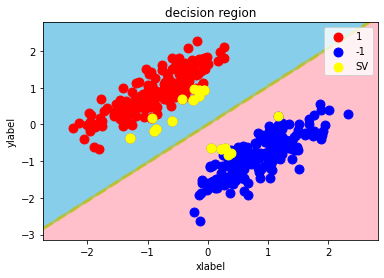

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['1', '-1']):
    
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = svm.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')

    #サポートベクトルの表示を追加
    plt.scatter(svm.X_sv[:, 0], svm.X_sv[:, 1], s=80, color='yellow', label="SV", marker='o')

    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

y_train = y_train.flatten() 
decision_region(X_train_transformed, y_train, svm.fit(X_train_transformed, y_train))